<a href="https://colab.research.google.com/github/boemer00/deep_learning/blob/main/TF2_0_simple_rnn_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1: Load Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.layers import Normalization
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
from keras.optimizers import SGD, Adam

- input: sequence of length `T`
- output: next values (scalar)
- count from `t=0` ... `len(series) - T`

While a Linear Regression expects a 2D input (NxT),
RNN expects 3D input (NxTx1).

shape (N x T x D)
- **N** = number of samples
- **T** = sequence length
- **D** = number of features


a single time-series input will be a 1D array of length T.

model.predict(x.reshape(1, T, 1))[0,0]
- reshape by (1,T,1) because the number of samples is 1 and the number of feature dimension is also 1.
- the output is going to be 1x1 because N is 1, and K is 1.
- to get the value as a scaler we need to index it as 0, twice.

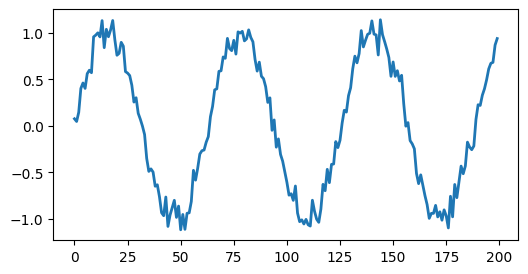

In [2]:
# Create the sine wave data with some noise
series = np.sin(0.1 * np.arange(200)) + np.random.randn(200) * 0.1

# Plot the sine wave using seaborn
plt.figure(figsize=(6, 3))  # (width, height)
sns.lineplot(x=np.arange(200), y=series, linewidth=2)
plt.show()

In [3]:
T = 10

In [4]:
series[1:1+T]

array([0.04809157, 0.14654207, 0.40307895, 0.46192607, 0.40366344,
       0.5619821 , 0.59896616, 0.57192544, 0.9575961 , 0.97603751])

In [5]:
series[1+T]

1.0007129072181562

In [6]:
series[1:12]

array([0.04809157, 0.14654207, 0.40307895, 0.46192607, 0.40366344,
       0.5619821 , 0.59896616, 0.57192544, 0.9575961 , 0.97603751,
       1.00071291])

In [7]:
print(len(series) - T)
print(len(series))

190
200


In [8]:
# build the dataset
T = 10 # T past values to predict the next value
D = 1  # the number of features in each time step of the series
X = [] # input sequences
Y = [] # target output

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)

  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (190, 10, 1) Y.shape (190,)


## Part 2: Initialize the Model

In [14]:
def initialize_model():
  # architecture
  model = Sequential()
  model.add(SimpleRNN(20, return_sequences=True, input_shape=(T,1)))
  model.add(SimpleRNN(10, input_shape=(T,1)))
  model.add(Dense(1))

  # compile
  model.compile(loss='mse',
                optimizer=Adam(lr=0.1))

  return model

In [15]:
# initialize your model
model = initialize_model()

# train the model
history = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
    verbose=0
)

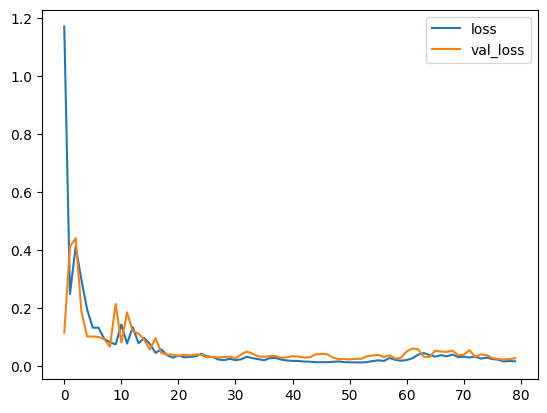

In [16]:
# plot loss per iteration
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend();

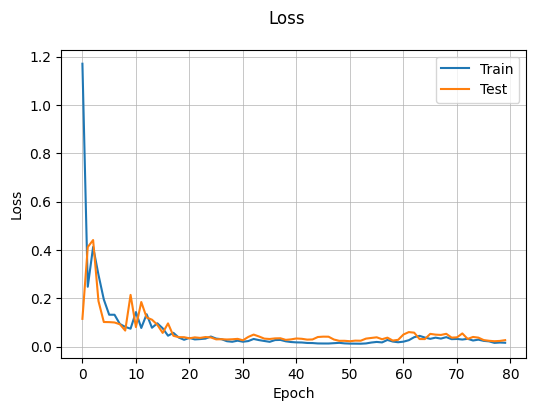

In [19]:
def plot_loss(history, title=None):
    fig, ax = plt.subplots(figsize=(6,4))

    # --- LOSS ---

    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])

    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')

    ax.legend(['Train', 'Test'], loc='best')

    ax.grid(axis="x", linewidth=0.5)
    ax.grid(axis="y", linewidth=0.5)

    if title:
        fig.suptitle(title)

plot_loss(history, title='Loss')

Usually, beginners would make sequential predictions without using previous previous predictions. This is misleading. Here is why:

In [22]:
# "Wrong" forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1, -1, 1))[0,0] # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

1/1 [==============================] - 0s 26ms/step


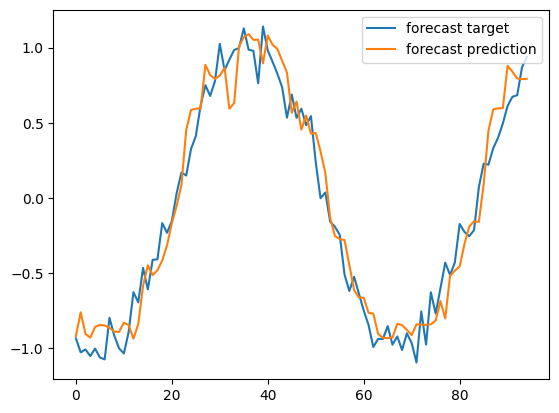

In [24]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend();

The graph above shows the model performs great, but that is not the reality. When making predictions on a sequence with an RNN, we often need to use previous predictions because the value at a certain time step is dependent on the values at earlier time steps. This is especially true in tasks like time series forecasting.

For example, let's say we have trained an RNN to forecast stock prices. We have a sequence of stock prices for the last N days, and we want to predict the stock prices for the next M days. For the first prediction (N+1 day), we can use the last N days of actual data as input to the RNN. But for the next prediction (N+2 day), we don't have the actual price for the N+1 day (as this is in the future). So, we have to use the predicted price for the N+1 day as part of the input to predict the price for the N+2 day. This process is then repeated for the remaining days.

## Part 3: Recursive Prediction (Forecast)

**`.reshape(1, -1, 1)`** where:
- the first dimension is the batch size (1 in this case).
- the second dimension is used as a placeholder for the size of the dimension that should be inferred from the original data, while keeping the other dimensions intact. It is the `seq_length`.
- the third dimension is set to 1 to represent a single feature (assuming univariate time series data).

In [20]:
# Define the targets for validation
# This is the data that the model tries to predict
validation_target = Y[-N//2:]

# An empty list that will hold the predictions made by the model
validation_predictions = []

# The initial input for the model
# It's the first element of the last half of array X (1D array of length T)
last_x = X[-N//2]

# The loop will continue until we have as many predictions as we have validation targets
while len(validation_predictions) < len(validation_target):
    # The model makes a prediction based on the current input
    # This prediction is a single number (scalar)
    p = model.predict(last_x.reshape(1, -1, 1))[0,0]

    # The prediction is added to the list of predictions
    validation_predictions.append(p)

    # The input is updated for the next prediction
    # All elements of the input array are shifted one step to the left
    # And the prediction is added as the last element of the input array
    last_x = np.roll(last_x, -1)
    last_x[-1] = p


1/1 [==============================] - 0s 25ms/step


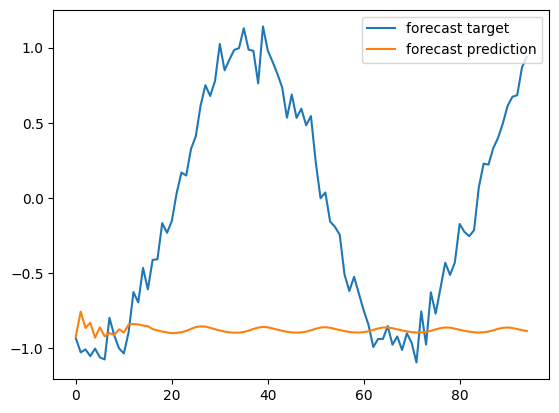

In [21]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend();

The model has a extremely poor performance. Therefore further fine tuning and/or experimenting with different types of layers, such as **LSTM** (Long Short-Term Memory) or **GRU** (Gated Recurrent Units). These layers can often capture long-term dependencies better than **SimpleRNN**.